In [1]:
main_directory="/Users/samuelcourville/Documents/JPL/combinedModel/"

# required stuff
import sys
sys.path.insert(1, main_directory+'thermal')
sys.path.insert(1, main_directory+'aqueous')
sys.path.insert(1, main_directory+'transport')
sys.path.insert(1, main_directory+'rock')
sys.path.insert(1, main_directory+'tables')
sys.path.insert(1, main_directory+'plotting')
import matplotlib.pyplot as plt
import numpy as np

# 1). Import WOW!

In [2]:
# import WOW (WOW! Ocean Worlds)
import WOW

# 2). Create model grid

In [3]:
######### define grid ##############

nr = 50                  # Number of radii
maxnt = 4000             # Maximum number of time steps


YR    =   3.1536E7        #(seconds in a year, for easy conversion)
StartTime=2.5 * 10**6*YR  # Start time in seconds after CAIs  
EndTime = 4567* 10**6*YR  # End time in seconds after CAIs. Stop time if maxnt is not reached
Radius  = 480000          # Radius in meters



# parameters for perplex grid
temp_step = 15 # how many degrees (K) change before recalculating thermal properties? 
press_step= 10 # how many radius points between each perplex equilibration calculation?


# Initialize the planet
Ceres = WOW.Planet(nr,StartTime,EndTime,Radius,maxnt,temp_step,press_step)

# 3). Initialize model composition

### 3a starting temperature

In [4]:
# Starting temperature
init_Temp = 180   # K

### 3b starting bulk composition

In [5]:
########### initialize comp ############

# Ice composition
init_IceComp={'H2O':100.0}#,'C':0.272,'O':0.728} #,'CO':0,'NH3':2.0,'CH4':0} #,'NH3':0.1, 'CO2'}

# Rock composition
init_RockComp={"H":4.751,"C":2.784,"Mg":7.313,"Al":0.676,"Si":7.746,"S":4.020,"Ca":0.693,"Fe":14.001,"O":57.196,"Na":0.403,"N":0.417}

# Organic matter C-H-O abundances (relative to C)
Cr = 1.0
Hr = 0.65
Or = 0.17

# Mass fractions of ice and organics relative to rocks
ICE_frac = 0.02
OrgFrac  = 0.02 # percentage of rock that is organics

#####################################################





# Don't change anything below
# Reweight rock and ice compositions so they sum to 1
# (Eventually this will be done behind the scenes)
sumR=0
for key in init_RockComp:    
    sumR = sumR+init_RockComp[key]
    init_RockComp[key] *= (1-OrgFrac)/100
    init_RockComp[key] *= (1.0-ICE_frac)
    
sumI=0
for key in init_IceComp:    
    sumI = sumI+init_IceComp[key]
    init_IceComp[key] *= (ICE_frac/100)

# Organic composition
init_orgMass=OrgFrac*(1.0-ICE_frac)
init_orgFrac=OrgFrac

Hwt= Hr*1
Cwt= Cr*12.01
Owt= Or*16
TotWt=Hwt+Cwt+Owt
Hwt=Hwt/TotWt*OrgFrac
Cwt=Cwt/TotWt*OrgFrac
Owt=Owt/TotWt*OrgFrac

init_orgComp={}
init_orgComp["H"]=Hwt/init_RockComp["H"]
init_orgComp["C"]=Cwt/init_RockComp["C"]
init_orgComp["O"]=Owt/init_RockComp["O"]

mOrg = init_RockComp["H"]*init_orgComp["H"]+init_RockComp["C"]*init_orgComp["C"]+init_RockComp["O"]*init_orgComp["O"]

init_RockComp["IOM"]=init_orgMass

### 3c starting radioisotope abundances

In [6]:
# Radioactive elements starting wt%
IceActual=0.20
Al_tot_abund=(1-IceActual)*(1-OrgFrac) * 8370*10**-6     
K_tot_abund= (1-IceActual)*(1-OrgFrac) * 559*10**-6      
U_tot_abund= (1-IceActual)*(1-OrgFrac) * 0.00816*10**-6  
Th_tot_abund=(1-IceActual)*(1-OrgFrac) * 0.0298*10**-6   

# Radioisotope fractions
Al_26_27_start=5*10**-5    
K_40_39_today=0.0119/100 
U_235_238_today=0.71/100


# Don't edit below
# Calc initial radioisotope wt%
# (eventually this will be behind the scenes)
Al26start=Al_tot_abund*Al_26_27_start
K40start = WOW.calcOriginAbundance(K_tot_abund*K_40_39_today,"K40")
U235start= WOW.calcOriginAbundance(U_tot_abund*U_235_238_today,"U235")
U238start= WOW.calcOriginAbundance(U_tot_abund*(1-U_235_238_today),"U238")
Th232start=WOW.calcOriginAbundance(Th_tot_abund,"Th232")
# Initial radioisotope abundance
init_Radio={'Al26':Al26start,'K40':K40start,'U235':U235start,'U238':U238start,'Th232':Th232start}
print(init_Radio)

{'Al26': 3.28104e-07, 'K40': 6.234571834112383e-07, 'U235': 4.095898590790737e-09, 'U238': 1.2904569594572835e-08, 'Th232': 2.9291962262911986e-08}


### 3d intial bulk properties

In [7]:
# Starting bulk properties (will be updated after first perplex calculation)
init_rho = 1700 # kg/m^3
init_K   = 3.6  # Thermal conductivity
init_Cp  = 1444 # Heat capacity

# initialize!
Ceres.initialize_comp("ceres",init_IceComp,init_RockComp, init_Radio, init_Temp,init_rho,init_K,init_Cp)

# 4). Run Model

What makes the model slow:
- Reading thermal properties from a csv file for every time and radius step. 
    - Solution: read in all thermal property coefficients from csv at start of runtime and store a variable.
- Executing Perplex. Every Perplex execution requires opening R, loading the Rcrust package, and closing.
    - Solution: skip Rcrust, run Perplex fortran code directly. Likely need to modify fortran code though.
- Executing EQ36 aqueous equilibration at every time and radius step.
    - Solution: Only execute a new equilibration when a significant pressure, temperature, composition change has been made

In [8]:
Ceres.runModel()

Step 0 out of 4000
Step 10 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 20 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 30 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 40 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 50 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 60 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 70 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 80 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 90 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 100 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 110 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 120 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 130 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 140 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 150 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 160 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 170 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 180 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 190 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 200 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 210 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 220 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 230 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 240 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 250 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 260 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 270 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 280 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 290 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 300 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 310 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 320 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 330 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 340 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 350 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 360 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 370 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 380 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 400 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 410 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 420 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 430 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 440 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 450 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 460 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 470 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 480 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine instead.
The mineral Amph_2 is not in my tables. Using olivine instead.
The mineral Amph_3 is not in my tables. Using olivine i

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 510 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 520 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 530 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 540 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 550 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

Step 560 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 570 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 580 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 590 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 600 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 610 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 620 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 630 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 640 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 650 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 660 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 670 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 680 out of 4000
Step 690 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 700 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 710 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 720 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 730 out of 4000
Step 740 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 750 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 760 out of 4000
Step 770 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 780 out of 4000
Step 790 out of 4000
Step 800 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 810 out of 4000
Step 820 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 830 out of 4000
Step 840 out of 4000
Step 850 out of 4000
Step 860 out of 4000
Step 870 out of 4000


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


Step 880 out of 4000
Step 890 out of 4000
Step 900 out of 4000
Step 910 out of 4000
Step 920 out of 4000
Step 930 out of 4000
Step 940 out of 4000
Step 950 out of 4000
Step 960 out of 4000
Step 970 out of 4000
Step 980 out of 4000
Step 990 out of 4000
Step 1000 out of 4000
Step 1010 out of 4000
Step 1020 out of 4000
Step 1030 out of 4000
Step 1040 out of 4000
Step 1050 out of 4000
Step 1060 out of 4000
Step 1070 out of 4000
Step 1080 out of 4000
Step 1090 out of 4000
Step 1100 out of 4000
Step 1110 out of 4000
Step 1120 out of 4000
Step 1130 out of 4000
Step 1140 out of 4000
Step 1150 out of 4000
Step 1160 out of 4000
Step 1170 out of 4000
Step 1180 out of 4000
Step 1190 out of 4000
Step 1200 out of 4000
Step 1210 out of 4000
Step 1220 out of 4000
Step 1230 out of 4000
Step 1240 out of 4000
Step 1250 out of 4000
Step 1260 out of 4000
Step 1270 out of 4000
Step 1280 out of 4000
Step 1290 out of 4000
Step 1300 out of 4000
Step 1310 out of 4000
Step 1320 out of 4000
Step 1330 out of 4000


# 5). Plot results!

In [9]:
stime=Ceres.times[0] /3.154e+7/1e6 # convert model time to Myrs
etime=Ceres.times[-1]/3.154e+7/1e6 # convert model time to Myrs

# print mass of planet
print(Ceres.Mass)

7.875193667571656e+20


### 5.1 Plot temperature

(2.4996829422954976, 4439.68556559859)

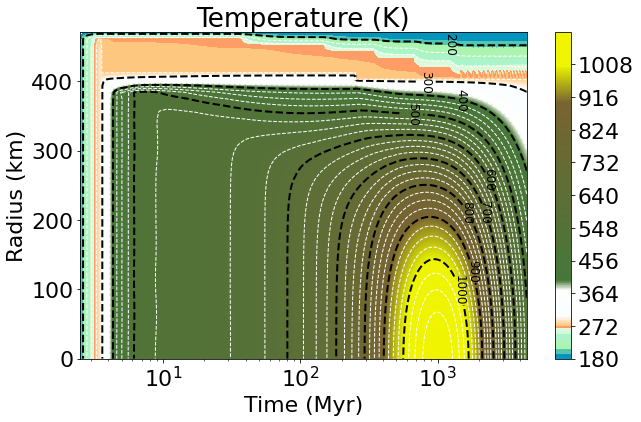

In [10]:
Ceres.plotTemp("Temp","Temperature (K)")
plt.xscale("log")
plt.xlim([stime,etime])

### 5.2 Plot mineral phases
 - All phases

ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
ne
n

/Users/samuelcourville/Documents/JPL/combinedModel/WOW.py:1090: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j]=pP[i][j]/sumM[j]*(100-IOMp)


(2.4996829422954976, 4439.68556559859)

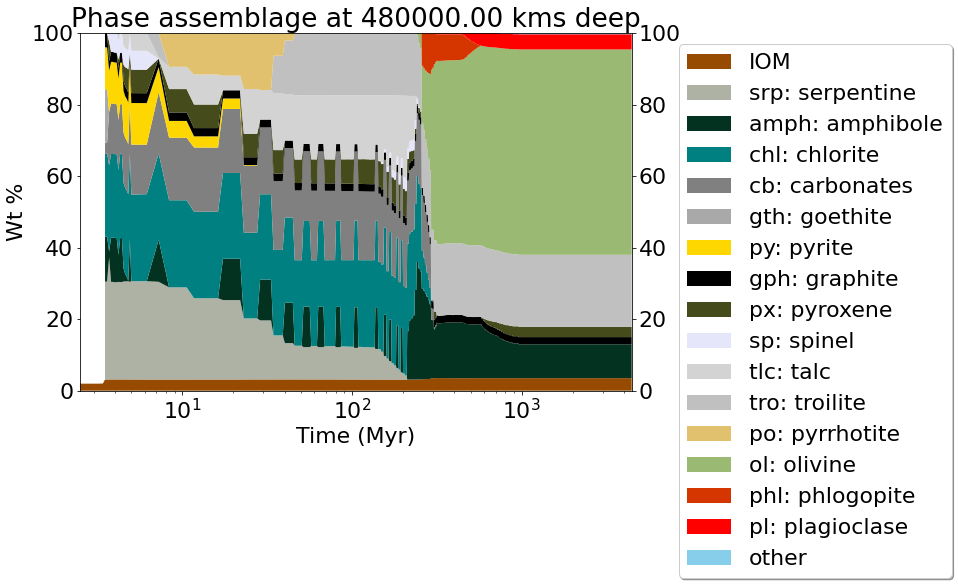

In [11]:
ax = Ceres.plotPhaseAssemblage(0,[])
plt.xscale("log")
plt.xlim([stime,etime])
#plt.legend(bbox_to_anchor=(1.6, 1.0), loc='upper right',
#                   ncol=1, fancybox=True, shadow=True)

- simplified

/Users/samuelcourville/Documents/JPL/combinedModel/WOW.py:947: RuntimeWarning: invalid value encountered in double_scalars
  pP[i][j] = pP[i][j] / sumM[j] * (100 - IOMp)


(2.4996829422954976, 4439.68556559859)

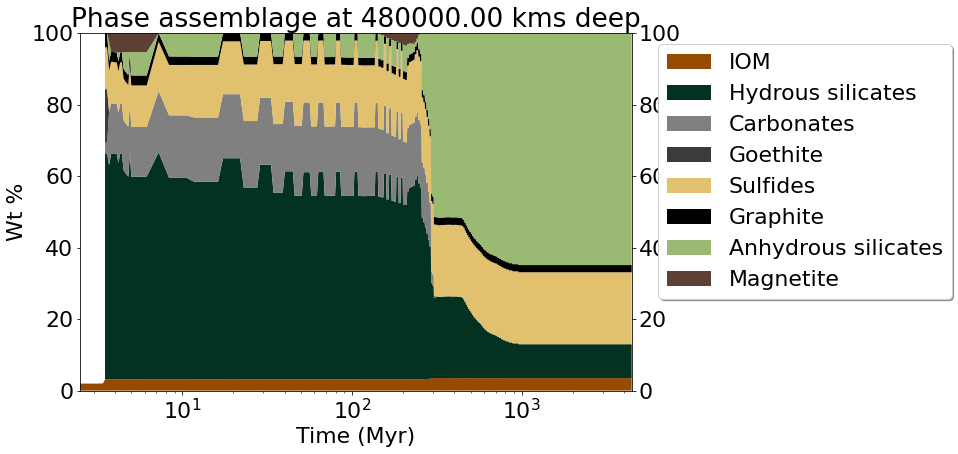

In [12]:
ax = Ceres.plotSimplePhases(0,["iron"])
plt.xscale("log")
plt.xlim([stime,etime])

### 5.3 Bulk properties
- heat capacity
- thermal conductivity
- density
- pressure

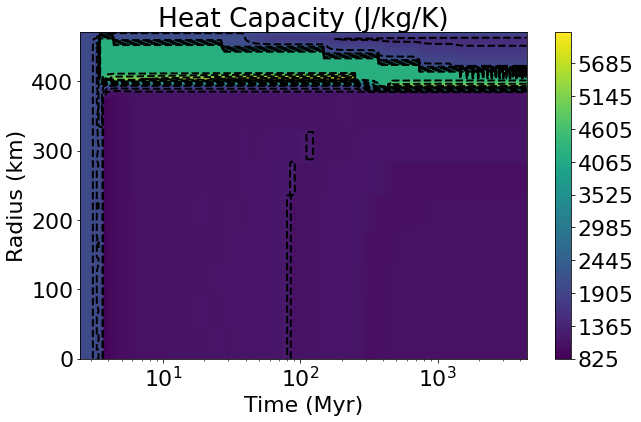

In [13]:
plt.rc('image', cmap='viridis')
Ceres.plotAttribute("Cp","Heat Capacity (J/kg/K)")
plt.xscale("log")

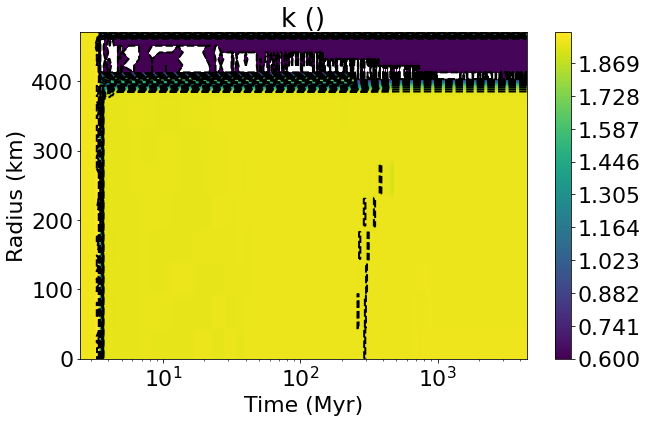

In [14]:
Ceres.plotAttribute("TCond","k ()")
plt.xscale("log")

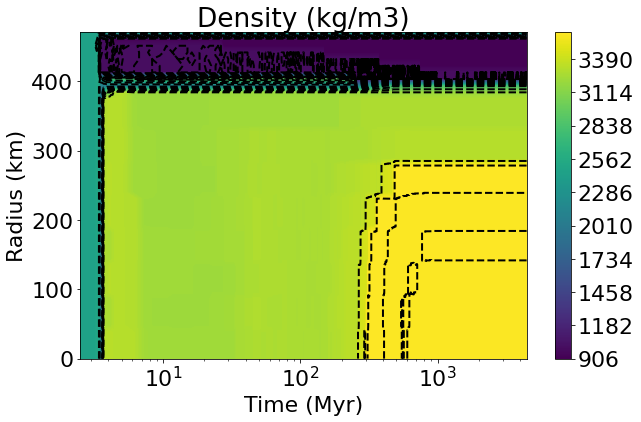

In [15]:
Ceres.plotAttribute("Dens","Density (kg/m3)")
plt.xscale("log")

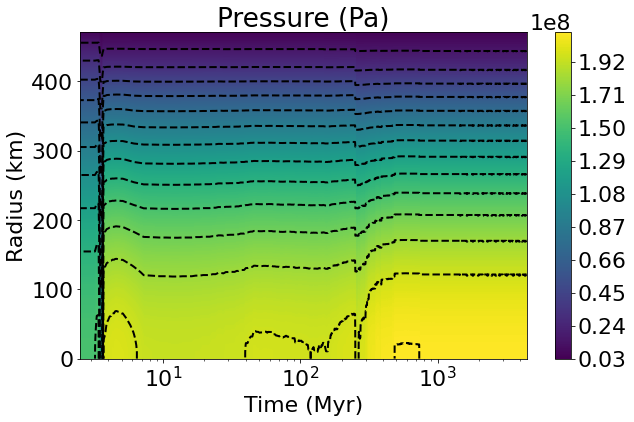

In [16]:
Ceres.plotAttribute("Press","Pressure (Pa)")
plt.xscale("log")

### 5.4 Radioisotope abundances

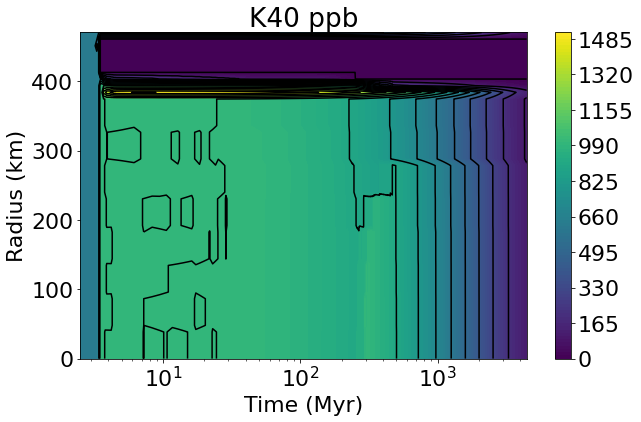

In [17]:
Ceres.plotDictAttribute("RIComp","K40","K40 ppb",10**9)
plt.xscale("log")

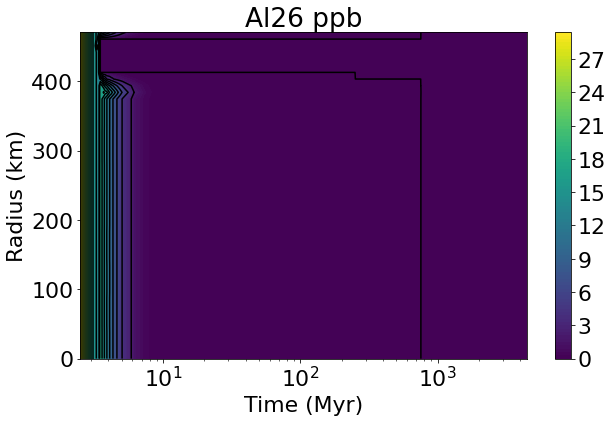

In [18]:
Ceres.plotDictAttribute("RIComp","Al26","Al26 ppb",10**9)
plt.xscale("log")

### 5.5 Structure
- Ocean mass

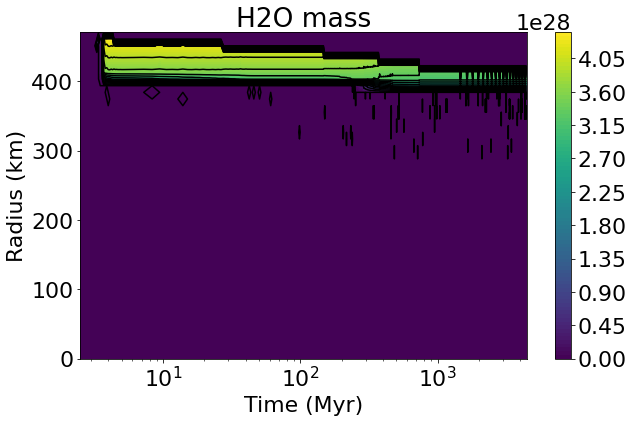

In [19]:
Ceres.plotDictAttribute("AqComp","H2O","H2O mass",10**9)
plt.xscale("log")

- Cell types (Rock, ocean, ice, or mixed)

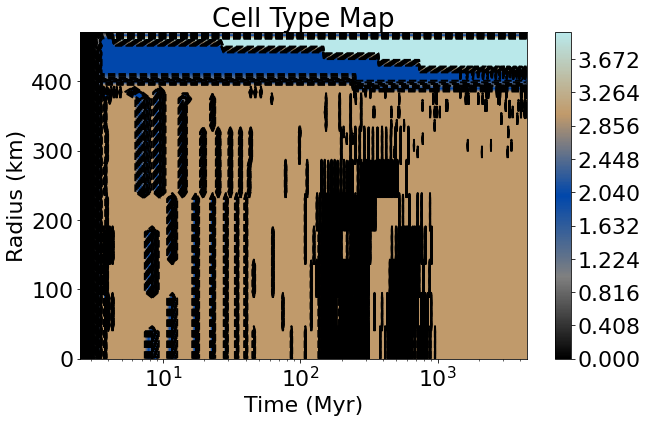

In [20]:
from matplotlib.colors import LinearSegmentedColormap
# Define the colors and ranges
colors = ['black', 'grey', '#0047AB', '#C19A6B', '#b9e8ea']
# Create a colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
plt.rc('image', cmap=custom_cmap)
Ceres.plotAttribute("Celltype","Cell Type Map")
plt.xscale("log")

### 5.6 Aqueous species in ocean
- Index ocean for species at that time

In [24]:
j=700      # time index
depth=43   # depth index
for i in Ceres.grid[j,depth].AqSpec:
    if Ceres.grid[j,depth].AqSpec[i]>10**-10:
        print(i+": "+str(Ceres.grid[j,depth].AqSpec[i])+" M")

H+: 3.3103e-07 M
Cl-: 0.00022317 M
OH-: 5.3494e-09 M
H2(aq): 1.3066e-10 M
SiO2(aq): 1.9284e-05 M
Fe++: 2.667e-06 M
Mg++: 0.00094209 M
CO2(aq): 0.90605 M
Al+++: 9.094e-10 M
NH4+: 2.4448 M
Methane(aq): 1.4996 M
HCO3-: 2.4456 M
MgCl+: 5.1234e-08 M
AlOH++: 1.8796e-09 M
NH3(aq): 0.00028695 M
Formic_acid(aq): 3.2273e-09 M
Formate: 2.7391e-06 M
HSiO3-: 5.3346e-09 M
Al(OH)2+: 3.323e-10 M
CO3--: 0.0011968 M
MgHCO3+: 0.0085796 M
Ethane(aq): 0.00023814 M
Acetic_acid(aq): 8.0281e-05 M
HAlO2(aq): 1.5097e-10 M
Acetate: 0.0067941 M
N2(aq): 0.0015967 M
MgCO3(aq): 3.4576e-05 M
Mg(For)+: 3.685e-08 M
Acetamide(aq): 0.013006 M
NH4CH3COO(aq): 0.011281 M
Fe(For)+: 1.7765e-10 M
MgCH3COO+: 6.8611e-05 M
Methionine(aq): 0.0063943 M
Propanoate: 0.00022358 M
AlCH3COO++: 7.7363e-10 M
FeCH3COO+: 1.1453e-07 M
Propanoic_acid(aq): 3.4388e-06 M
Propane(aq): 3.2463e-06 M
Urea(aq): 1.0318e-06 M
Oxalate: 4.9575e-10 M
Malonate: 4.7195e-08 M
Mg(Prop)+: 6.0797e-07 M
H-Malonate: 9.2972e-10 M
Butanoate: 2.1488e-06 M
NH4(CH3COO

- Sulfur species

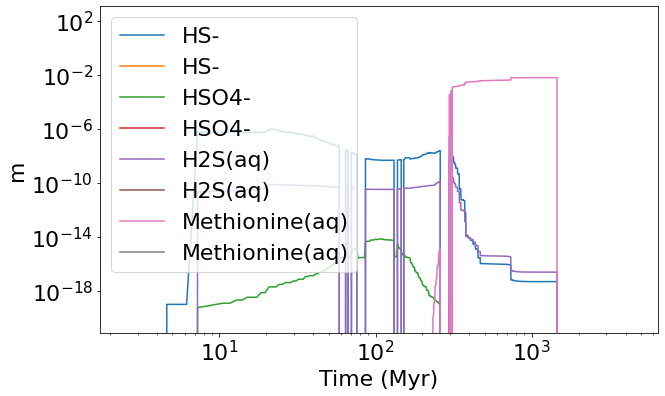

In [25]:
depth=43   # depth index

Ceres.multiplotDictAttributeLine("AqSpec",["HS-","HSO4-","H2S(aq)","Methionine(aq)"],"m",depth,1)
plt.yscale('log')
plt.xscale('log')

# Legend duplicates species for some reason (need to fix)

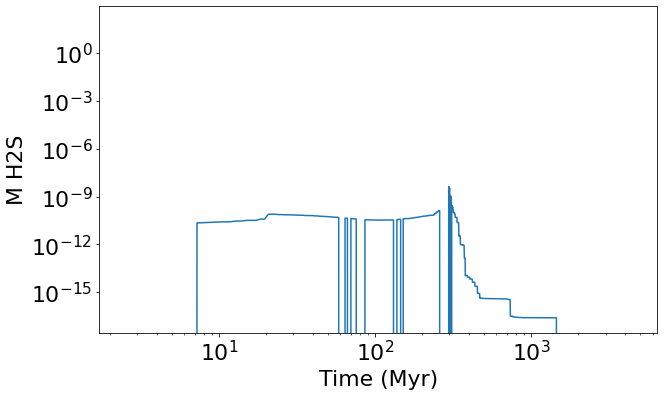

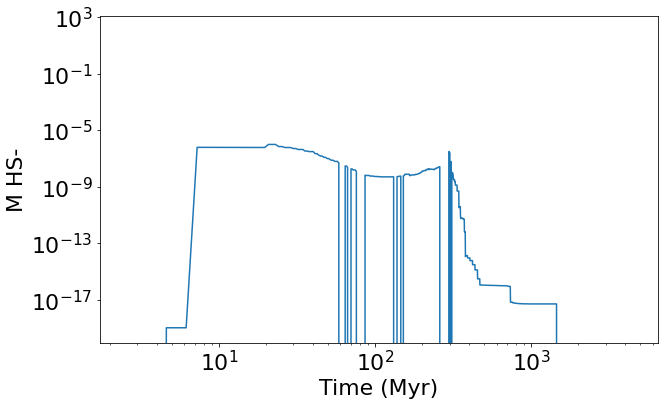

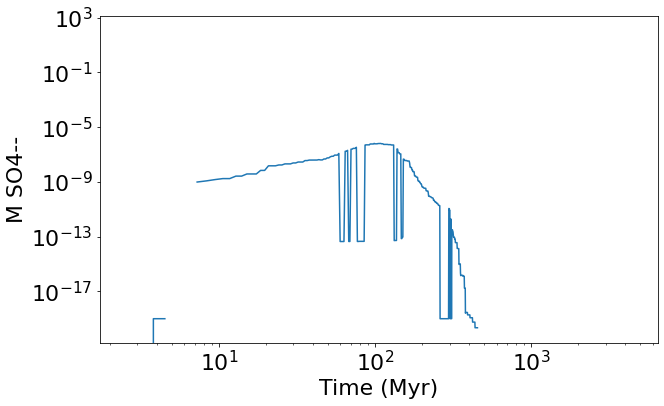

In [27]:
depth=43   # depth index

f,H2S=Ceres.plotDictAttributeLine("AqSpec","H2S(aq)","M H2S",depth,1)
plt.yscale('log')
plt.xscale('log')
f,HS=Ceres.plotDictAttributeLine("AqSpec","HS-","M HS-",depth,1)
plt.yscale('log')
plt.xscale('log')
f,SO4=Ceres.plotDictAttributeLine("AqSpec","SO4--","M SO4--",depth,1)
plt.yscale('log')
plt.xscale('log')


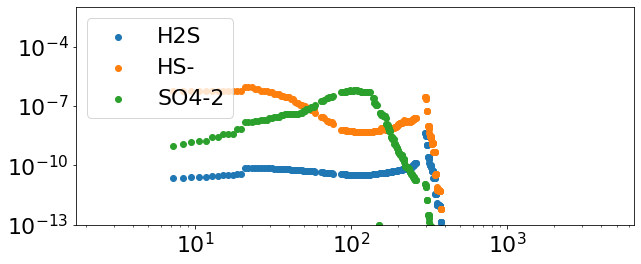

In [28]:
axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,H2S,label="H2S")
plt.scatter(Ceres.times/3.154e+7/1e6,HS,label="HS-")
plt.scatter(Ceres.times/3.154e+7/1e6,SO4,label="SO4-2")
#plt.scatter(Ceres.times/3.154e+7/1e6,Meth,label="Methionine")
plt.legend(loc="upper left")
plt.ylim([10**-13,10**-2])
plt.yscale('log')
plt.xscale('log')

- basic carbon species

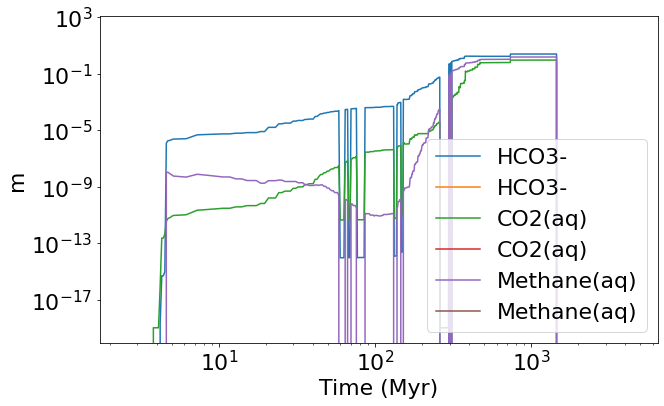

In [29]:
depth=43   # depth index
Ceres.multiplotDictAttributeLine("AqSpec",["HCO3-","CO2(aq)","Methane(aq)"],"m",depth,1)
plt.yscale('log')
plt.xscale('log')

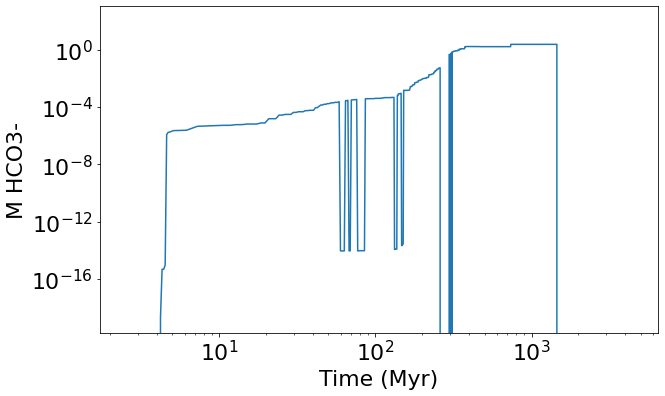

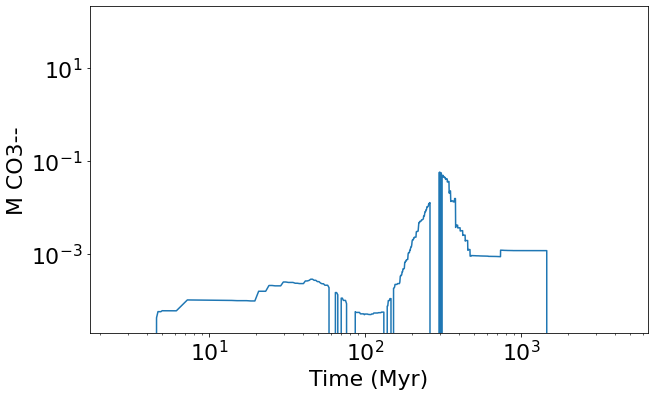

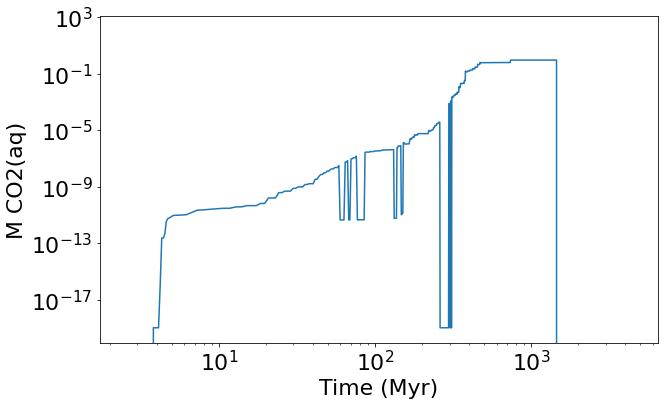

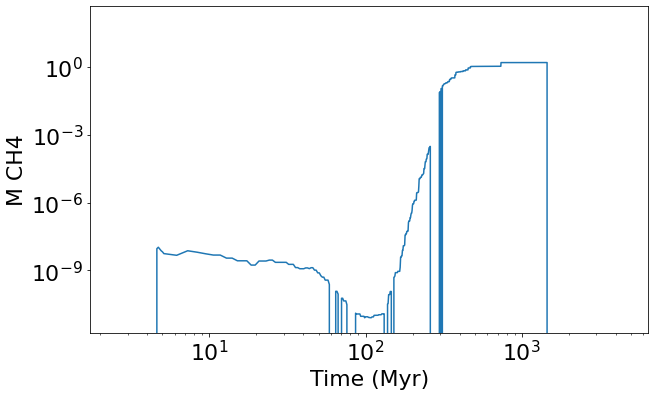

In [30]:
depth=43   # depth index

f,HCO3=Ceres.plotDictAttributeLine("AqSpec","HCO3-","M HCO3-",depth,1)
plt.yscale('log')
plt.xscale('log')
f,CO3=Ceres.plotDictAttributeLine("AqSpec","CO3--","M CO3--",depth,1)
plt.yscale('log')
plt.xscale('log')
f,CO2=Ceres.plotDictAttributeLine("AqSpec","CO2(aq)","M CO2(aq)",depth,1)
plt.yscale('log')
plt.xscale('log')
f,CH4=Ceres.plotDictAttributeLine("AqSpec","Methane(aq)","M CH4",depth,1)
plt.yscale('log')
plt.xscale('log')

# Plotting functions not working right now (need to fix)
# See combined plot below

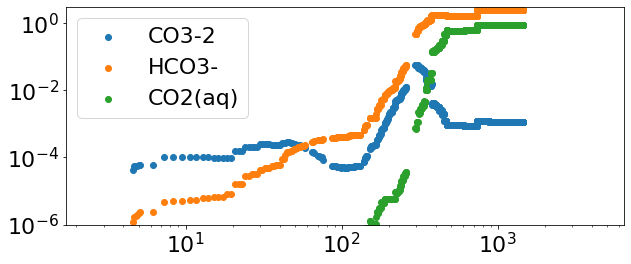

In [31]:
axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,CO3,label="CO3-2")
plt.scatter(Ceres.times/3.154e+7/1e6,HCO3,label="HCO3-")
plt.scatter(Ceres.times/3.154e+7/1e6,CO2,label="CO2(aq)")
#plt.scatter(Ceres.times/3.154e+7/1e6,CH4,label="CH4(aq)")
plt.legend()#location="NW")
plt.ylim([10**-6,3])
plt.yscale('log')
plt.xscale('log')

- pH

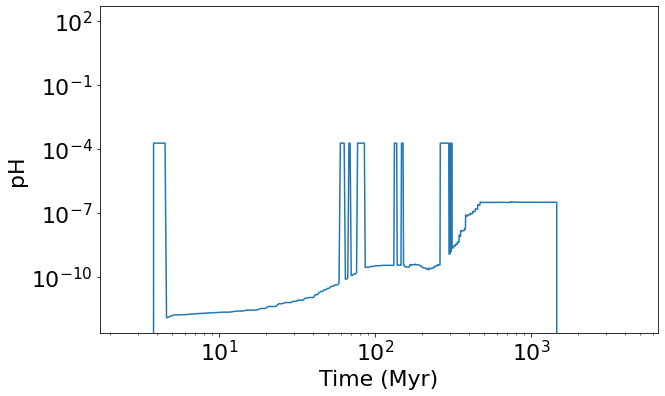

In [32]:
depth=43   # depth index

f,H=Ceres.plotDictAttributeLine("AqSpec","H+","pH",depth,1)
plt.yscale('log')
plt.xscale('log')

/var/folders/45/f1806xws7bs82y02k4l1kd180000gn/T/ipykernel_89090/917312887.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(Ceres.times/3.154e+7/1e6,-np.log10(H),color="k")


Text(0.5, 0, 'Time (Myr)')

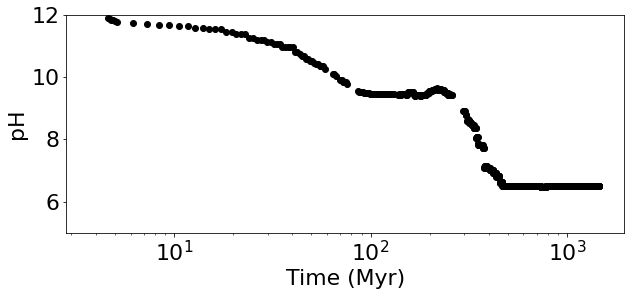

In [33]:

axes=plt.figure(figsize=(10,4))
plt.scatter(Ceres.times/3.154e+7/1e6,-np.log10(H),color="k")
plt.ylim([5,12])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel("pH")
plt.xlabel("Time (Myr)")

### 5.7 Volatiles added from core (work in progress)

(0.3978849266145215, 3.6473522129161804)

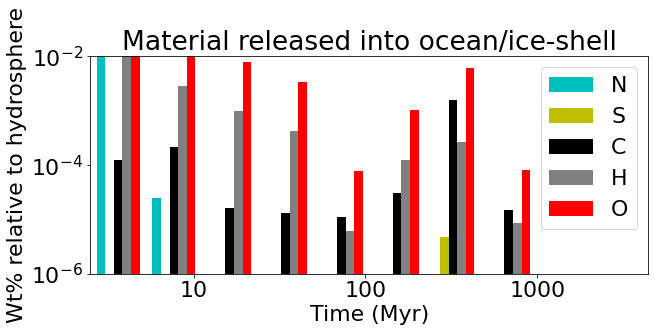

In [34]:
def plot_binned_bar_chart(X, Y, m,lab,col):
    n = len(X)
    # Check if m is valid
    if m >= n:
        raise ValueError("Number of bars (m) must be less than the length of the data (n)")
    # Calculate the bin size
    bin_size = n // m
    # Calculate the bin edges
    bin_edges = np.arange(0, n + bin_size, bin_size)
    # Create an array to store the binned values
    binned_values = np.zeros(m)
    bin_locs = np.zeros(m)
    # Bin the data
    Xlin=np.linspace(X[0],X[-1],len(X))
    for i in range(m):
        start_idx = bin_edges[i]
        end_idx = bin_edges[i + 1] if i < m - 1 else n
        bin_locs[i] = np.mean(Xlin[start_idx:end_idx])
        Xi1=np.argmin(np.abs(X-Xlin[start_idx]))
        Xi2=np.argmin(np.abs(X-Xlin[end_idx-1]))
        binned_values[i] = np.mean(Y[Xi1:Xi2])
    # Plot the binned bar chart
    plt.bar(bin_locs, binned_values, align='center',width=0.05,label=lab,color=col)
    plt.xlabel('Time (Myr)')
    plt.ylabel('Wt% relative to hydrosphere')
    plt.title('Material released into ocean/ice-shell')
    plt.yscale("log")
    #plt.show()

axes=plt.figure(figsize=(10,4))
for j in ["N","S","C","H","O"]:
    Car=np.zeros(maxnt)
    hydroM=np.zeros(maxnt)
    for i in range(0,maxnt):
        if j in Ceres.extracts[i]:
            Car[i]+=Ceres.extracts[i][j]
        for k in range(0,nr):
            hydroM[i]+=(Ceres.grid[i,k].AqMass+Ceres.grid[i,k].IceMass)
            if j in Ceres.grid[i,k].OrgComp:
                Car[i]+=Ceres.grid[i,k].OrgComp[j]
    #plt.plot(Ceres.times/3.154e+7/1e6,Car,label=j)
    logTimes = np.log10(Ceres.times/3.154e+7/1e6)
    offset=0
    col='k'
    mult=1
    if j=="H":
        offset=0.05
        col='grey'
        mult=1
    if j=="O":
        offset=0.1
        col='r'
    if j=="S":
        offset=-0.05
        col="y"
        mult=1
    if j=="N":
        offset=-0.1
        col="c"
    logTimes+=offset
    #plot_binned_bar_chart(logTimes, Car/Ceres.Mass/ICE_frac*100, 10,j,col)
    plot_binned_bar_chart(logTimes, mult*Car/hydroM*100, 10,j,col)

plt.legend()
plt.ylim([10**-6,10**-2])
plt.xticks([1, 2, 3], ['10', '100','1000'])
plt.xlim(np.log10([stime,etime]))
#plt.xscale('log')
#print(Ceres.Mass)